In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
import ctypes
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=12
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/04


In [2]:
diagnostics_df=pd.read_csv("./diagnostics.csv",index_col=0)
sigma_df=pd.read_csv('./sigma.csv',index_col=0)
ppd_df=pd.read_csv('./ppd.csv',index_col=0,sep='\t')
chi2_df=pd.read_csv('./sigma_chi2.csv',index_col=0)
#diagnostics_df1=pd.read_csv("./diagnostics_1.csv",index_col=0)
#sigma_df1=pd.read_csv('./sigma_1.csv',index_col=0)
#sigma_df=sigma_df.join(sigma_df1)
#diagnostics_df=diagnostics_df.join(diagnostics_df1)

In [11]:
chi2_df

,toybin0000,toybin0001,toybin0002,toybin0003,toybin0004,toybin0005,toybin0006,toybin0007,toybin0008,toybin0009,...,toybin9990,toybin9991,toybin9992,toybin9993,toybin9994,toybin9995,toybin9996,toybin9997,toybin9998,toybin9999
sigma,0.378179,0.249766,0.484092,0.303598,0.508258,0.508724,0.166705,0.189798,0.137372,0.247716,...,0.344087,0.156397,0.270653,0.261978,0.179707,0.196985,0.408795,0.314727,0.308960,0.214249
error,0.123406,0.110515,0.108940,0.083546,0.132533,0.115335,0.109061,0.127543,0.113352,0.129759,...,0.172400,0.120776,0.093621,0.114917,0.069733,0.069742,0.118379,0.074716,0.110178,0.121046


# Rhat diagnostics

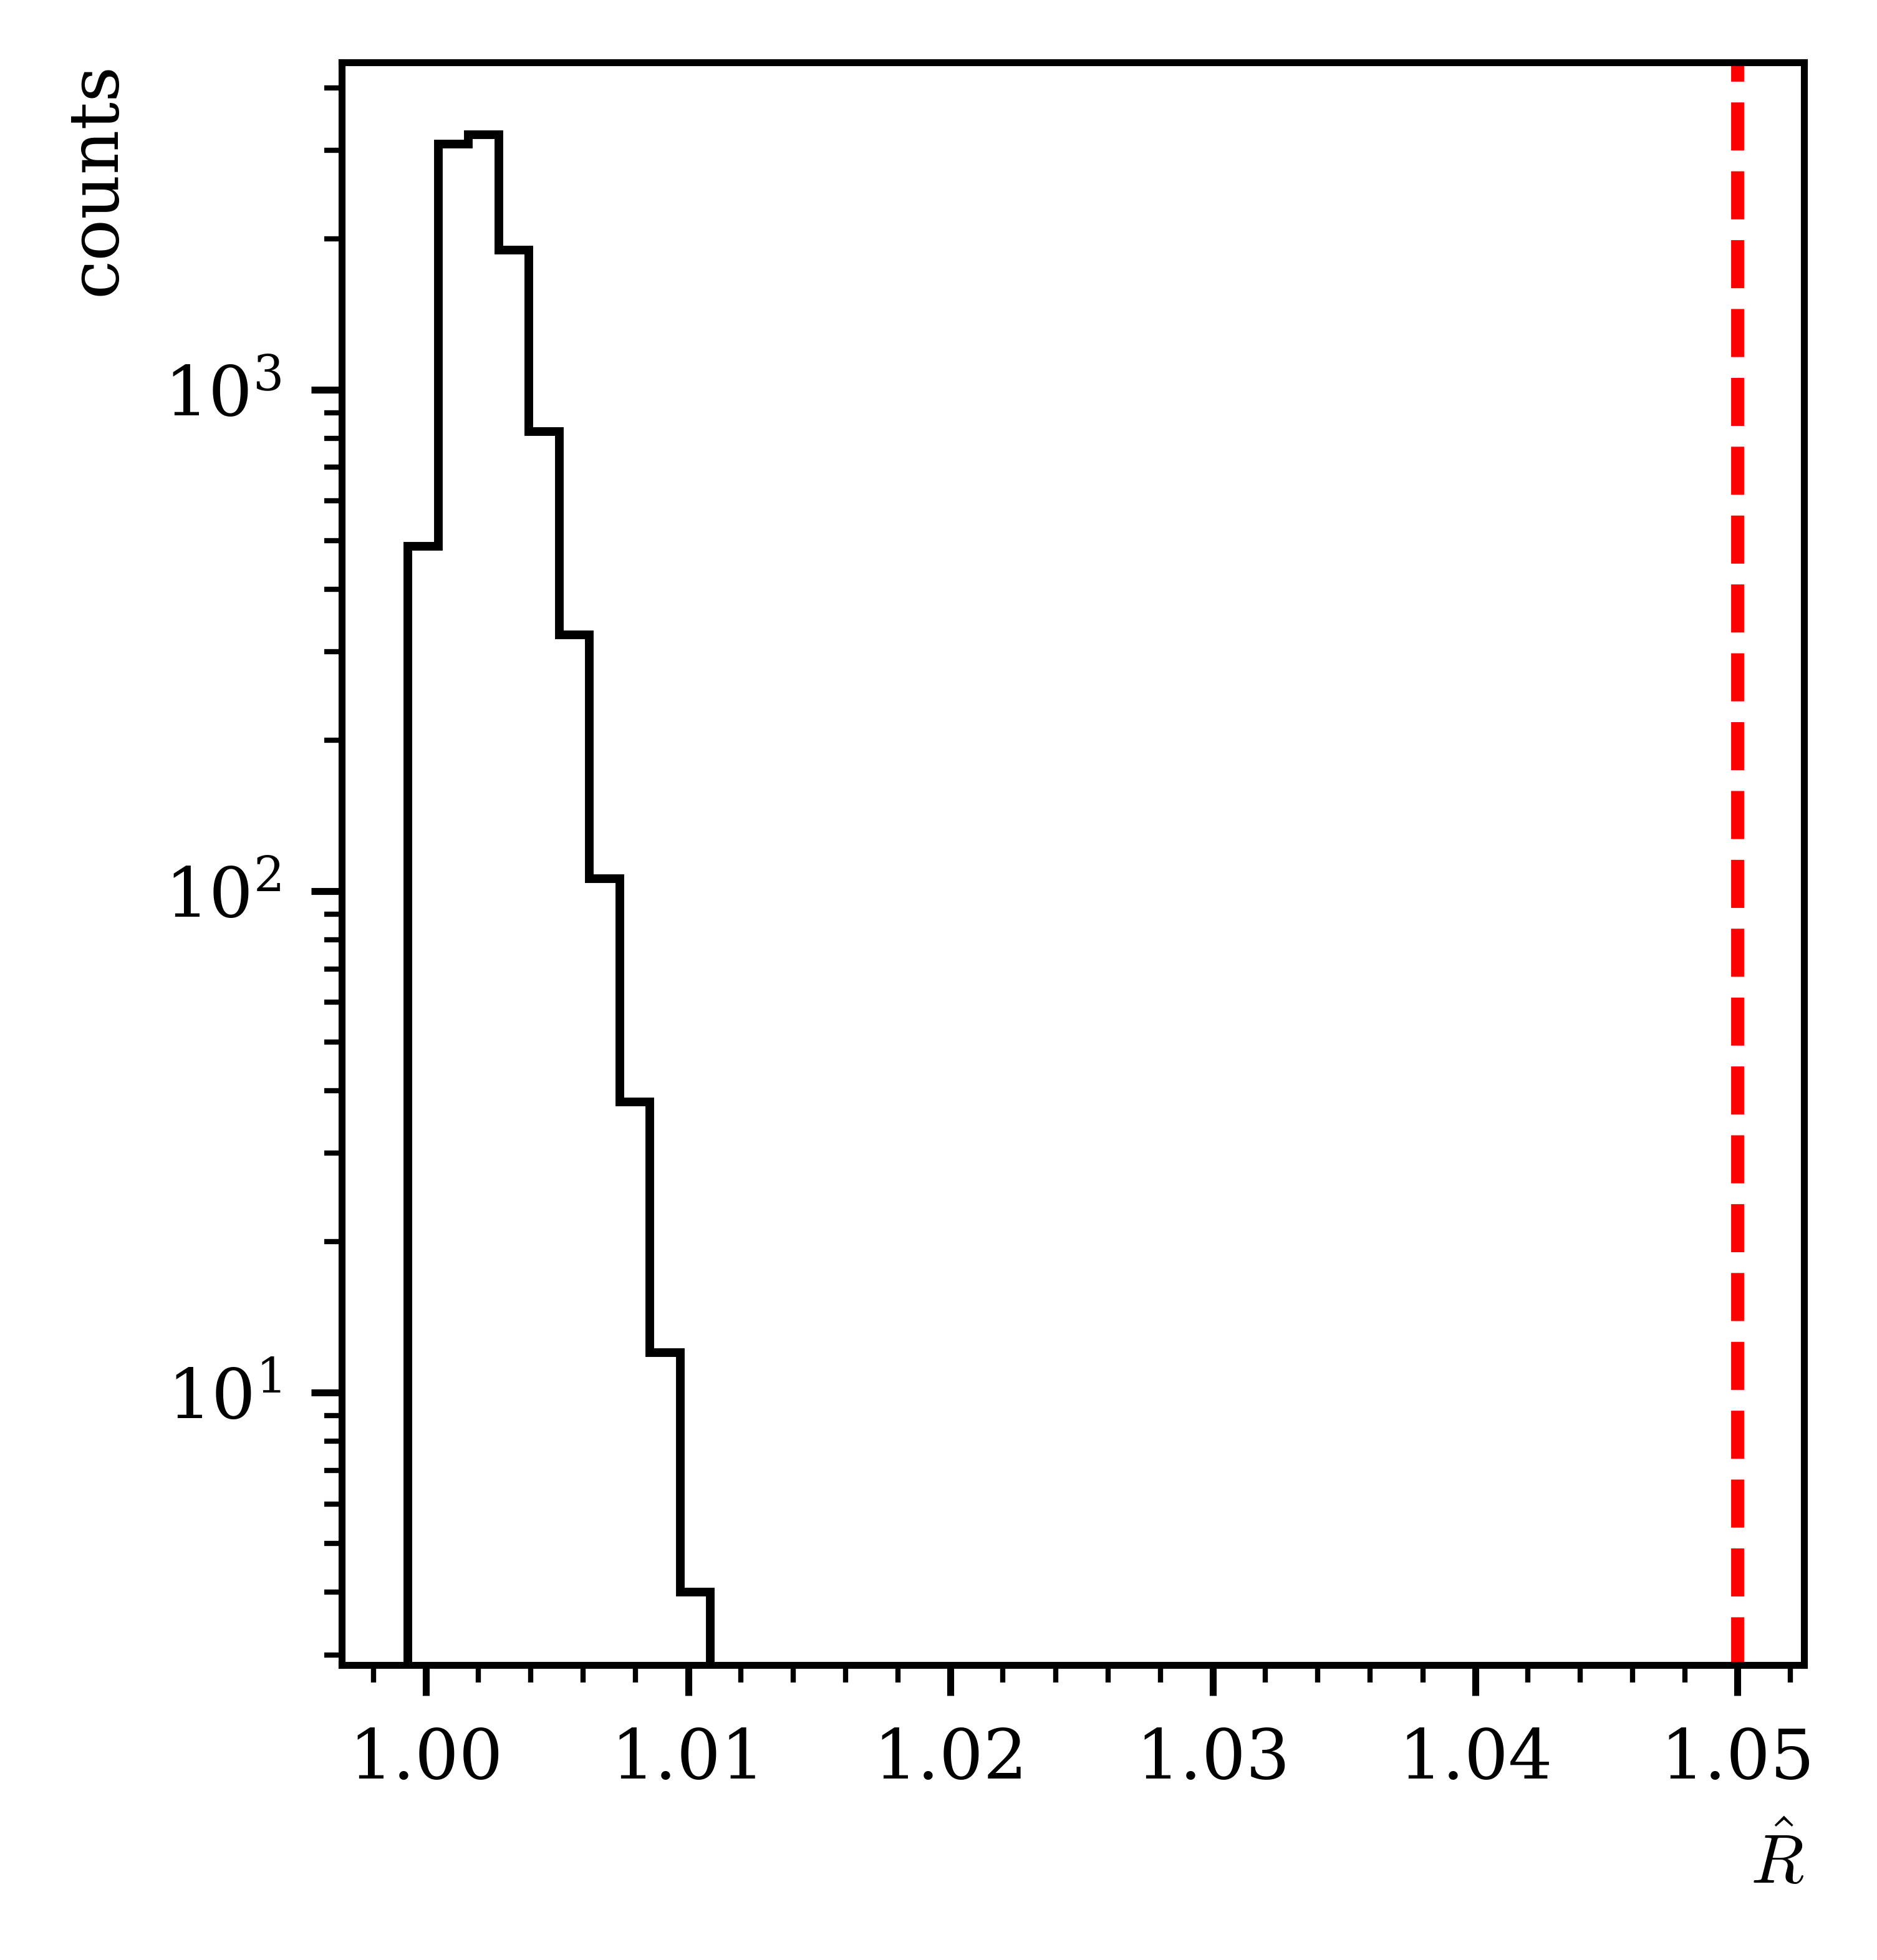

In [62]:
plt.rcParams['font.size']=8
fig, ax = plt.subplots(figsize=([15.3728/2.54/2,8.6472/2.54]),dpi=1000)

ax.hist(diagnostics_df.loc['rhat'].values,histtype='step',log=True)
#ax.set_xlim([0,1])
#plt.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)),histtype='step',bins=20)
ax.set_xlabel(r'$\hat{R}$',horizontalalignment='right',x=1.0)
#ax.set_xlabel(r'$\sigma_\mathrm{MCSE}/\mathrm{median}[p(\Sigma|y)]$',horizontalalignment='right',x=1.0)
ax.set_ylabel('counts',horizontalalignment='right',y=1.0)
ax.axvline(x=1.05,color='red',linestyle='--')
ax.grid(False)
#plt.xscale('log')
#plt.savefig('./plots/toyMC_mcse_hist_raw.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
fig.savefig('./plots/toyMC_rhat_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')

# Monte Carlo Standard Error

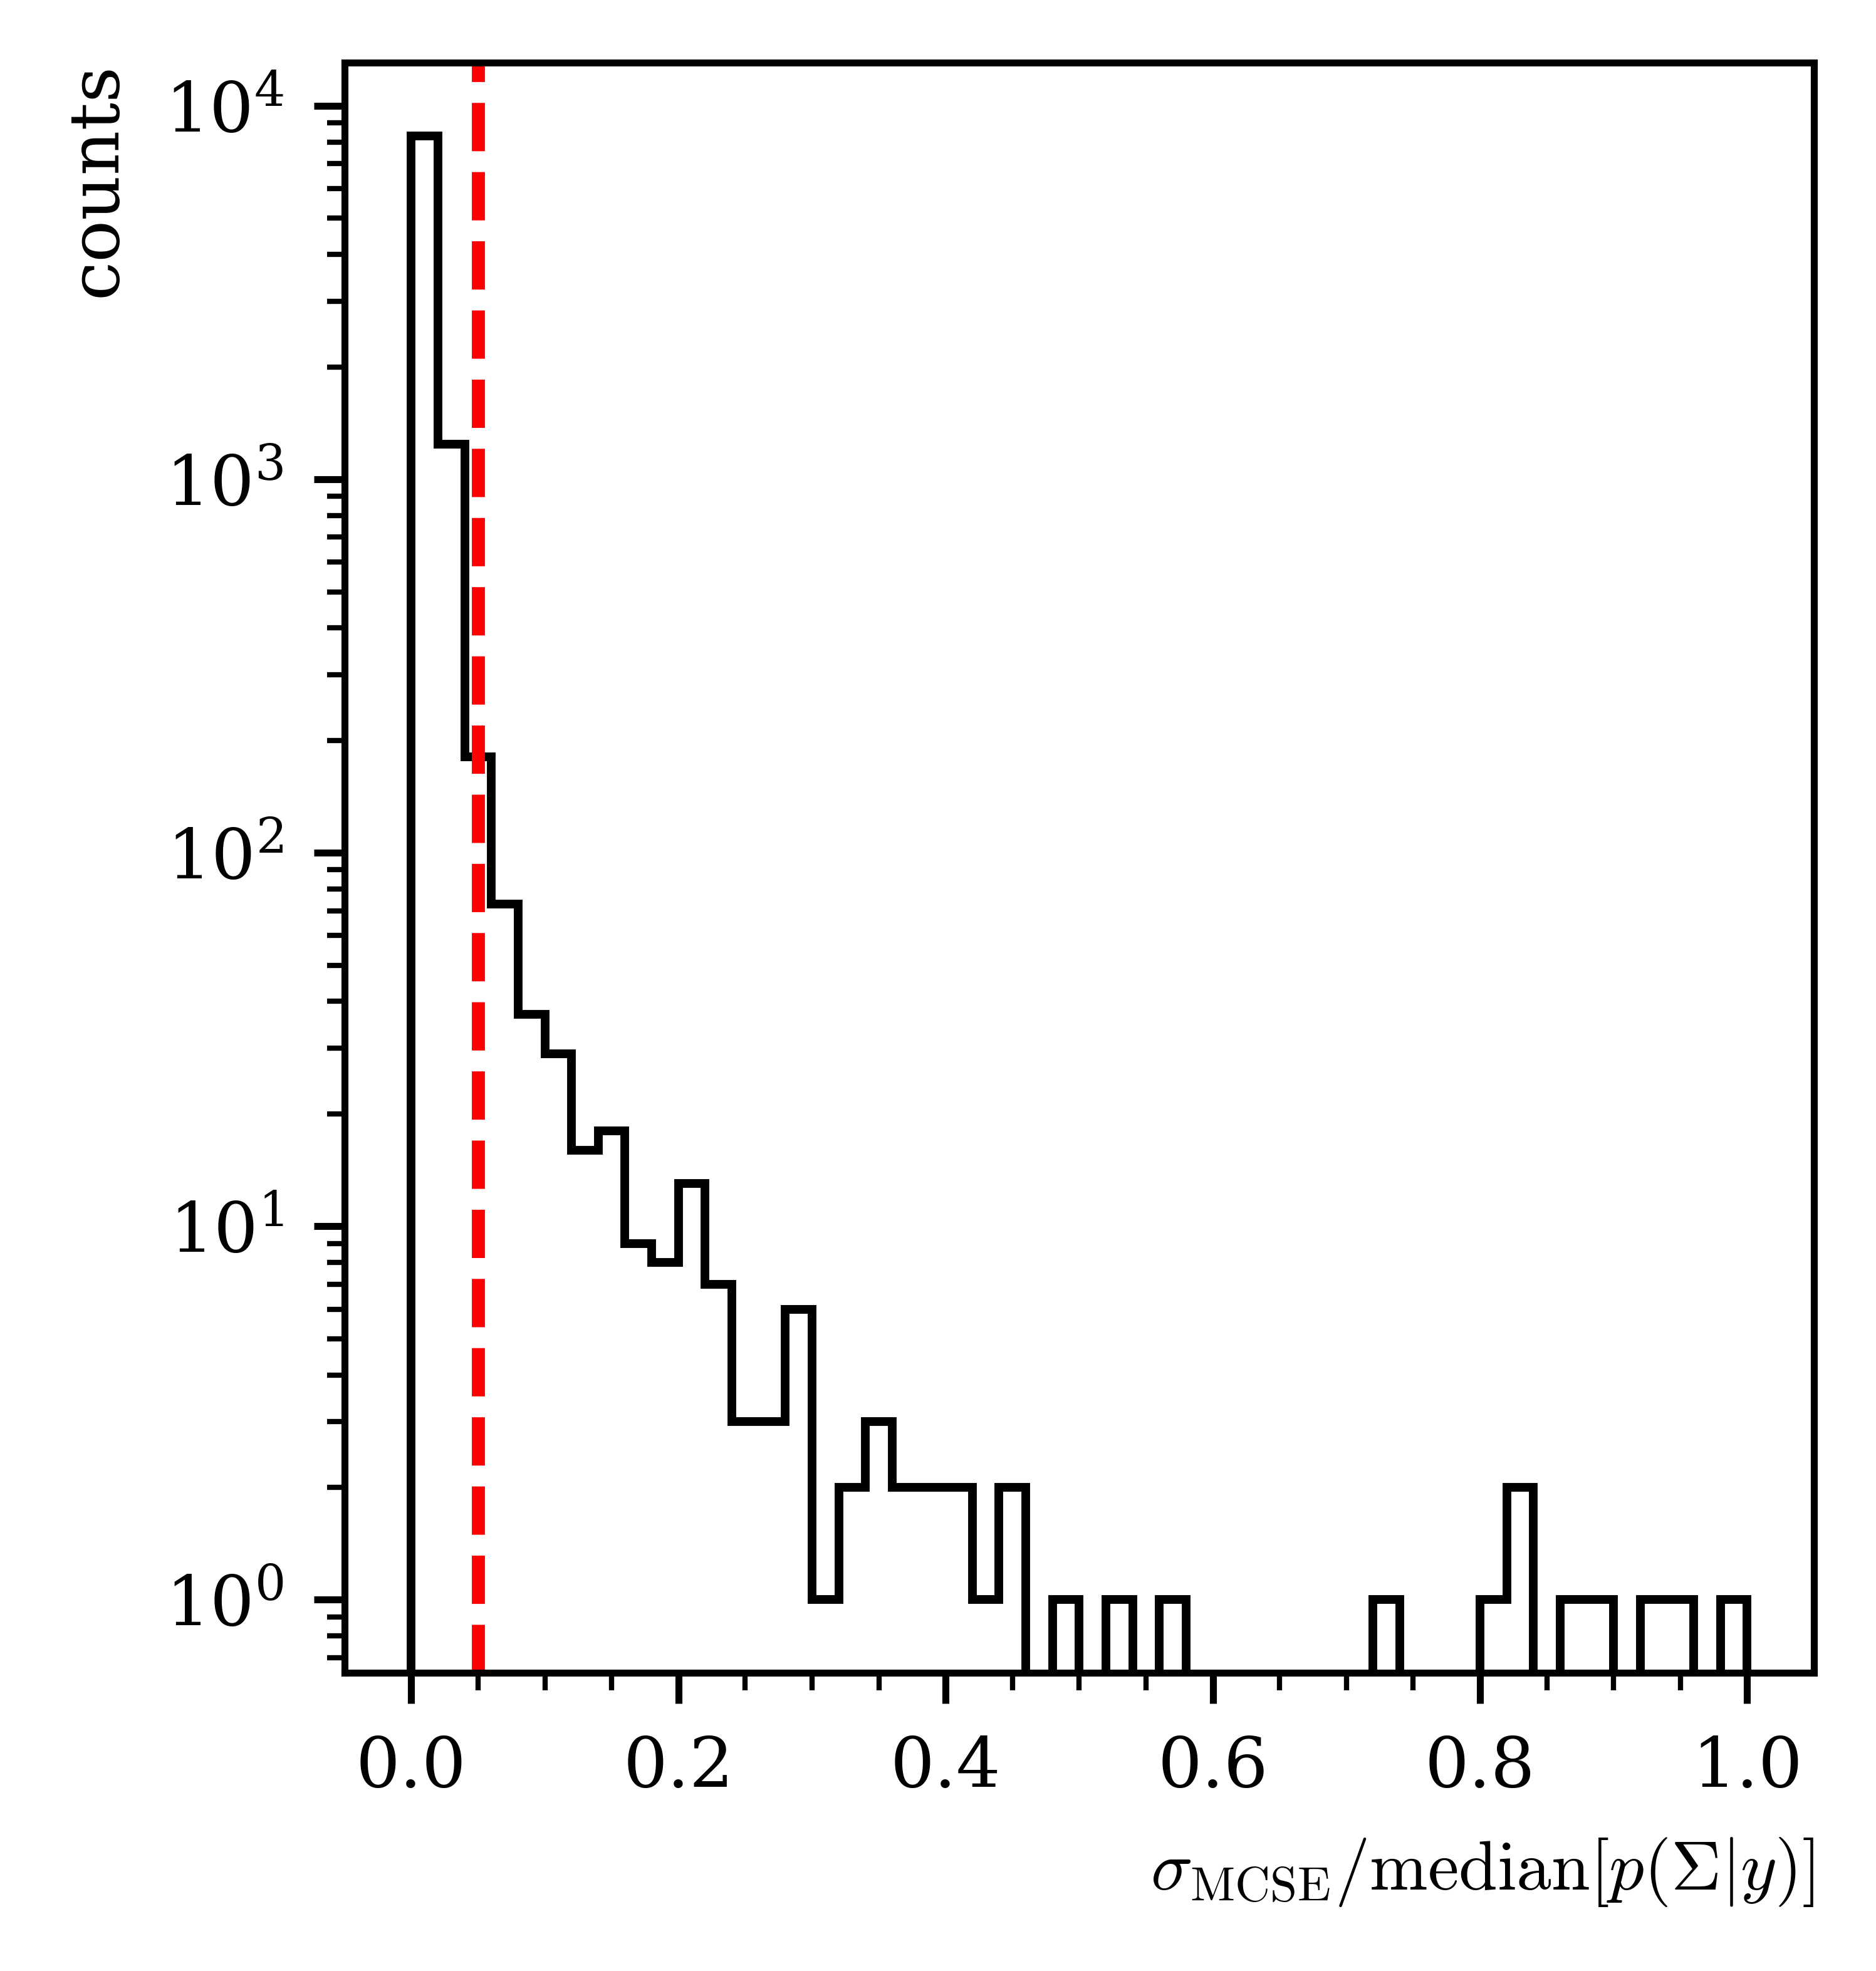

In [59]:
plt.rcParams['font.size']=8
fig, ax = plt.subplots(figsize=([15.3728/2.54/2,8.6472/2.54]),dpi=1000)

ax.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)/np.array(diagnostics_df.loc['sigma_median'].values)),histtype='step',log=True,range=[0,1],bins=50)
#ax.set_xlim([0,1])
#plt.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)),histtype='step',bins=20)
ax.set_xlabel(r'$\sigma_\mathrm{MCSE}/\mathrm{median}[p(\Sigma|y)]$',horizontalalignment='right',x=1.0)
ax.set_ylabel('counts',horizontalalignment='right',y=1.0)
ax.axvline(x=0.05,color='red',linestyle='--')
ax.grid(False)
#plt.xscale('log')
#plt.savefig('./plots/toyMC_mcse_hist_raw.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
fig.savefig('./plots/toyMC_mcse_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')

In [43]:
rel_err=np.abs(np.array(diagnostics_df.loc['mcse'].values)/np.array(diagnostics_df.loc['sigma_median'].values))
len(rel_err[rel_err<=0.05])/len(rel_err)

0.967

In [21]:
index=np.where(rel_err>=0.05)
np.array(diagnostics_df.loc['sigma_median'].values)[index]

array([], dtype=float64)

# Posterior Predictive Check for the first 6 toy MC bins

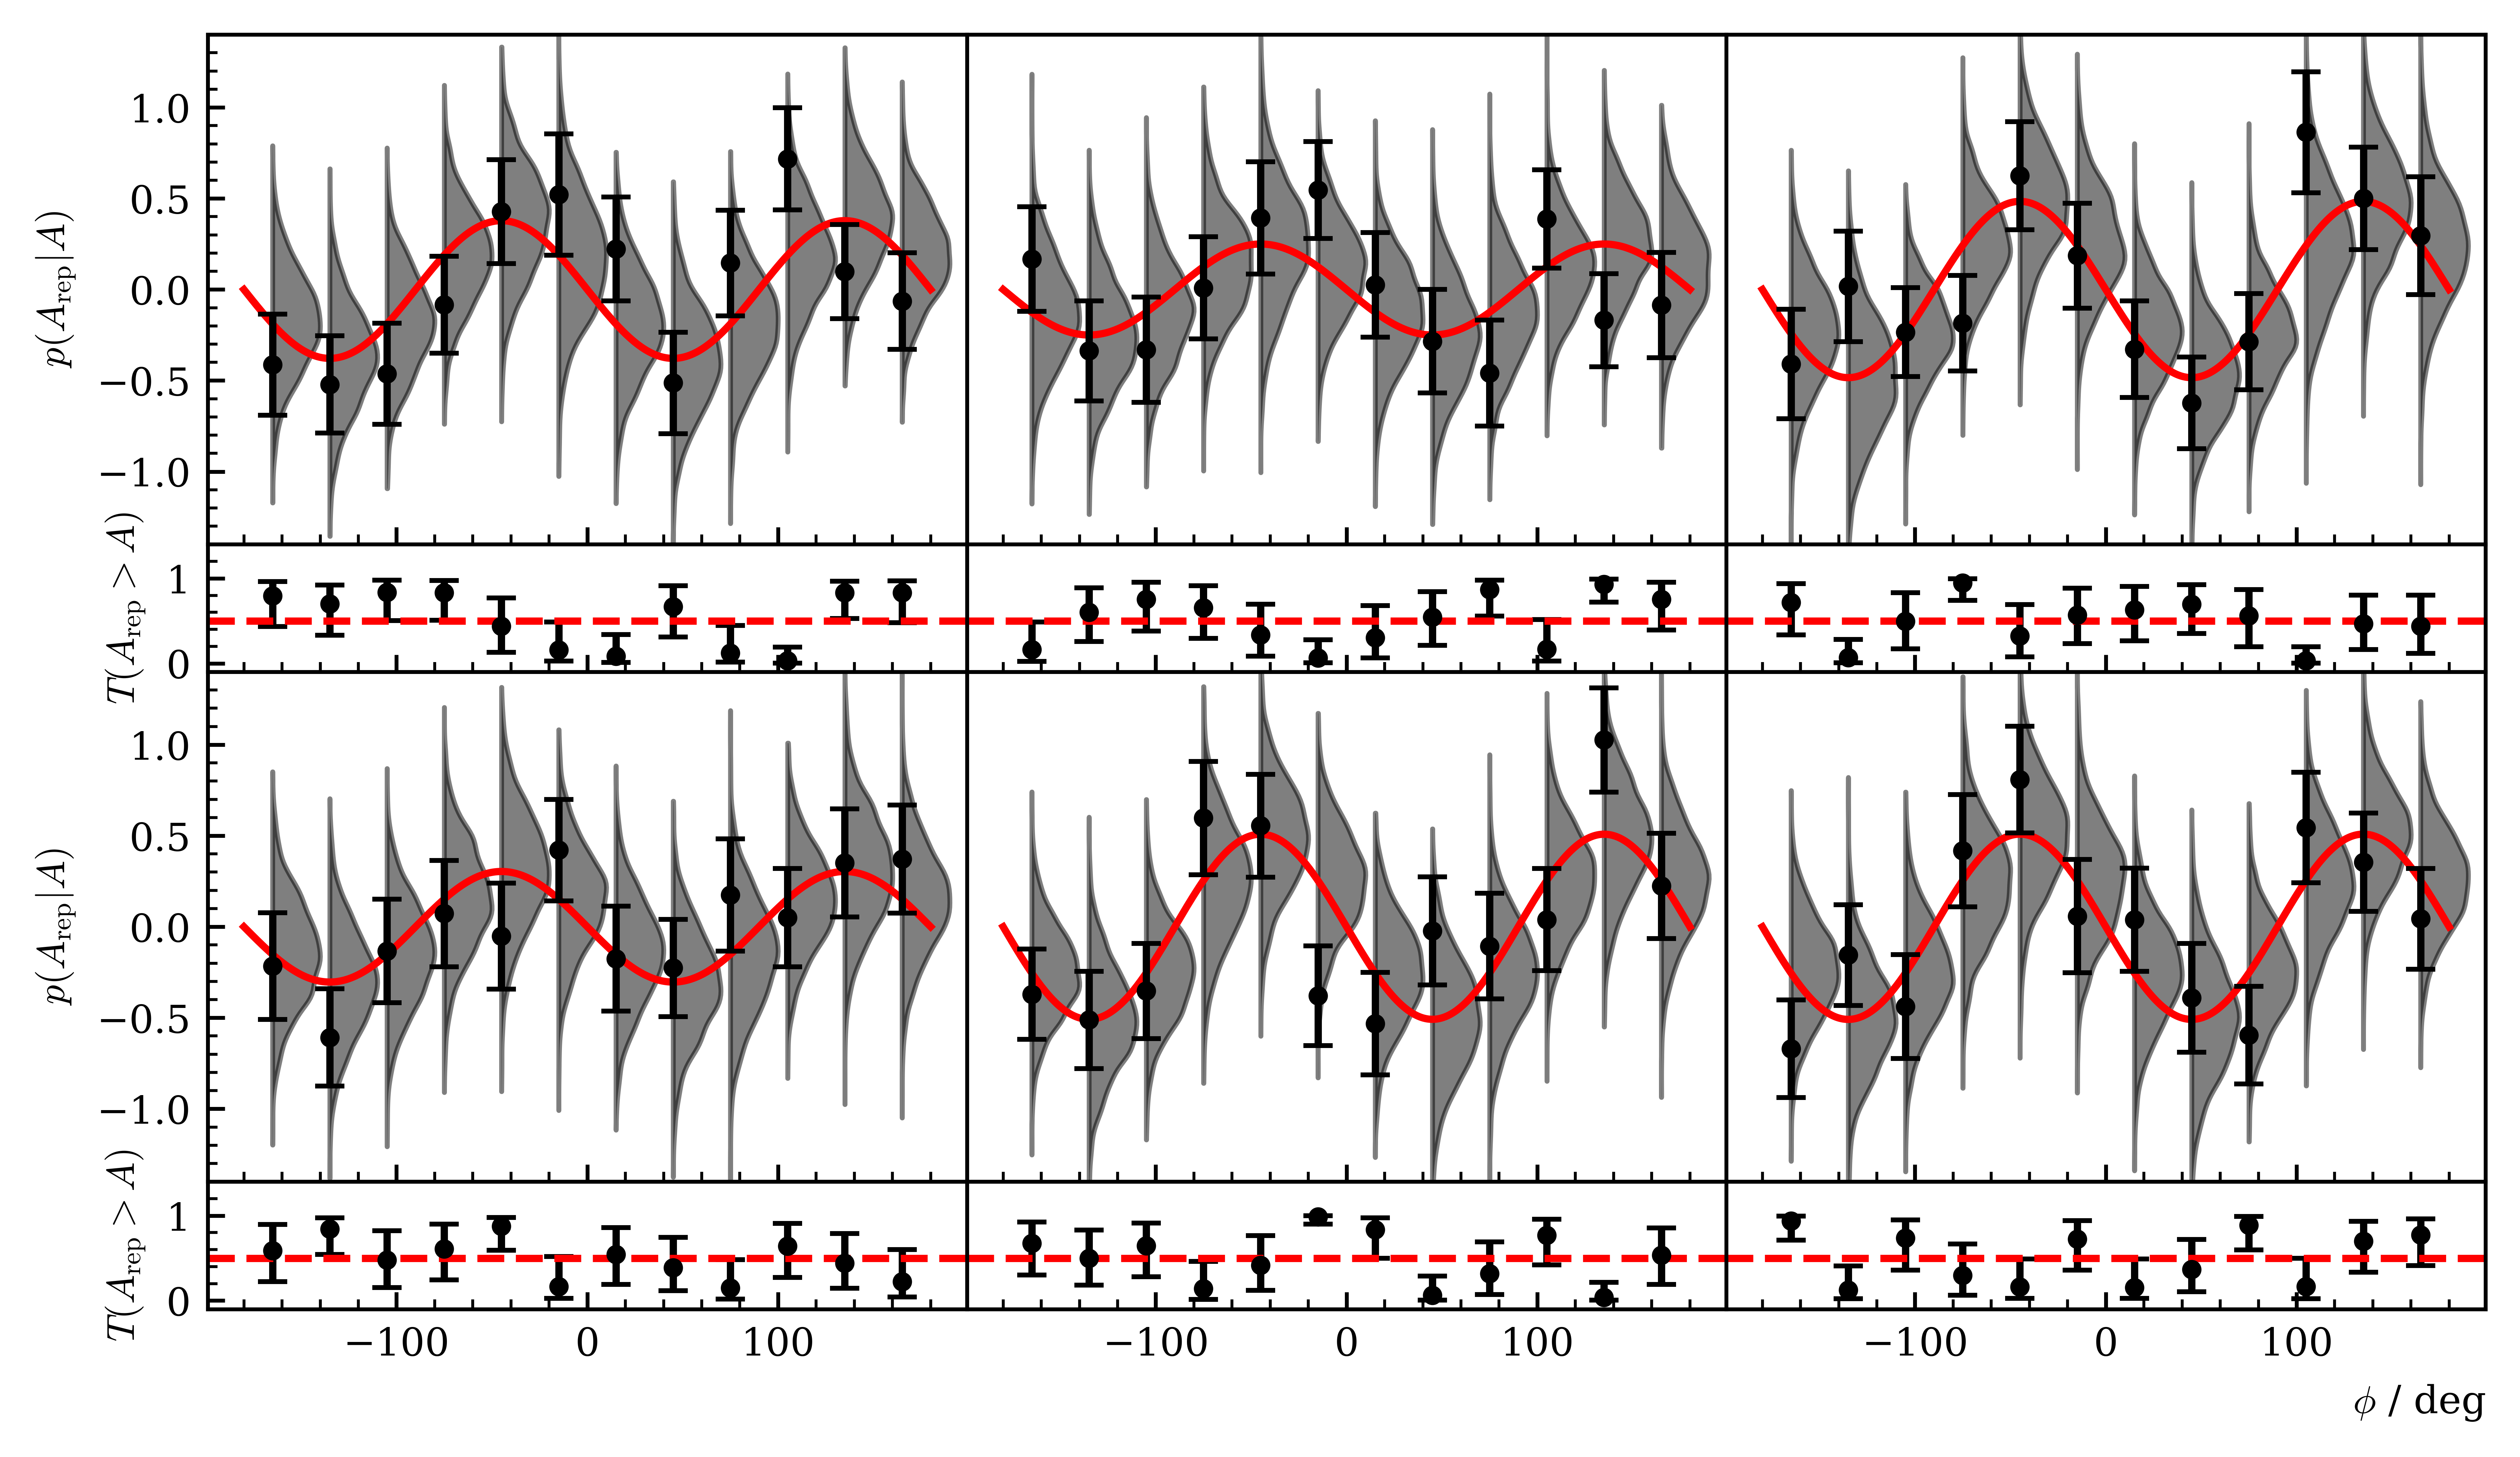

In [31]:
plt.rcParams['font.size']=8
fig = plt.figure(figsize=(21.41492/2.54,0.8*15.3728/2.54),dpi=1000)
outer = gridspec.GridSpec(2, 3, wspace=0, hspace=0)
nbinsphi=12
xvals=[-180+360/12/2+360/12*(i) for i in range(nbinsphi)]
for i in range(6):
    currbin=f"toybin{i:04d}"
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0, hspace=0,height_ratios=[4,1])

    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        #t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
        #t.set_ha('center')
        fig.add_subplot(ax)
        
        ax.set_xlim([-199,199])
        if(not(i==0 or i==3)):
            ax.set_yticks([])
        #these are plots of the asymmetry
        if j<1:
            #read data
            df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
            #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
            df.columns=['pol','setting','phi']
            #now write data to histo
            p45=df.loc[df['setting']==+45]
            m45=df.loc[df['setting']==-45]
        
            hp45=r.TH1F(f"hp45_{i}",";#phi;",nbinsphi,-180,180)
            hm45=r.TH1F(f"hm45_{i}",";#phi;",nbinsphi,-180,180)

            for k in p45['phi']:
                hp45.Fill(k)
            for k in m45['phi']:
                hm45.Fill(k)

            #now build event yield asymmetry
            #write histos to arrays
            p45_arr=[]
            m45_arr=[]
            for k in range(nbinsphi):
                p45_arr.append(hp45.GetBinContent(k+1))
                m45_arr.append(hm45.GetBinContent(k+1))
            
            p45_arr=np.array(p45_arr)
            m45_arr=np.array(m45_arr)
        
        
        
            #first, normalize event yields
            norm_p_err=ctypes.c_double(0.)
            norm_m_err=ctypes.c_double(0.)
        
            norm_p=hp45.IntegralAndError(0,-1,norm_p_err,"")
            norm_m=hm45.IntegralAndError(0,-1,norm_m_err,"")
        
            p45_arr*=1./norm_p
            m45_arr*=1./norm_m
            #c=r.TCanvas()

        

            #enumerator of asymmetry
            enum=p45_arr-m45_arr
            #nominator of asymmetry
            nom=0.25*p45_arr+0.3*m45_arr
            final_e=[]
            for k in range(nbinsphi):
                n_bot=hp45.GetBinContent(k+1)
                n_bot_err=hp45.GetBinError(k+1)
                #print(n_bot,n_bot_err)
                n_par=hm45.GetBinContent(k+1)
                n_par_err=hm45.GetBinError(k+1)
                pol_bot=0.3
                pol_par=0.25
            
                delta_nbot=np.sqrt(1/np.power(norm_p,4)*(np.power((norm_p-n_bot)*n_bot_err,2)
                                                     +n_bot*n_bot*(norm_p-n_bot)))
                delta_npar=np.sqrt(1/np.power(norm_m,4)*(np.power((norm_m-n_par)*n_par_err,2)
                                                     +n_par*n_par*(norm_m-n_par)))
            
            
            
                tmp_enum=(np.power(n_par/norm_m*(pol_bot+pol_par)*delta_nbot,2)
                        +np.power(n_bot/norm_p*(pol_bot+pol_par)*delta_npar,2))
            
            
                #tmp_nom=np.power(pol_par*n_bot*norm_m+pol_bot*n_par*norm_p,4)
                tmp_nom=np.power(pol_par*n_bot/norm_p+pol_bot*n_par/norm_m,4)
            
                final_e.append(np.sqrt(tmp_enum/tmp_nom))
        
        
            asym=enum/nom
            ax.set_ylim([-1.4,1.4])
            if(i==0 or i==3):
                ax.set_ylabel('$p(A_\mathrm{rep}|A)$')
            ytilde=[ppd_df[currbin+f'ytilde{i:02d}'] for i in range(12)]
            xx=np.linspace(-180,180,400)
            sigma_chi2=chi2_df[currbin]['sigma']
            yy=sigma_chi2*np.cos(2*np.pi/180.*(-45-xx))
            ax.plot(xx,yy,'r-',label='$\chi^2$ fit',color='red')
            #plot asymmetry
            ax.errorbar(x=xvals,y=asym,yerr=final_e,fmt='.',label='Data points',color='black')
            #violinplot for the replicated samples
            vp=ax.violinplot(ytilde,np.array(xvals),
                         showmeans=False, showextrema=False, showmedians=False,widths=50)
            #cosmetics
            for b in vp['bodies']:
                # get the center
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                # modify the paths to not go further right than the center
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
                b.set_alpha(.5)
                b.set_color('black')
            ax.tick_params(axis='both',which='both',direction='in')
        #plot p vals    
        else:
            ax.set_ylim([-0.1,1.4])
            ax.tick_params(axis='both',which='both',direction='in')
            pvalue=np.array([diagnostics_df[currbin].loc[f'pval{i:02d}'] for i in range(nbinsphi)])
            pvalue_lower=np.array([diagnostics_df[currbin].loc[f'pval_lerr{i:02d}'] for i in range(nbinsphi)])
            pvalue_upper=np.array([diagnostics_df[currbin].loc[f'pval_uerr{i:02d}'] for i in range(nbinsphi)])
            pval_errors=[pvalue_lower,pvalue_upper]
            #plot pvalue
            #ax1.grid(which='minor',color='grey',lw='.4')
            ax.errorbar(x=xvals,y=pvalue,yerr=pval_errors,fmt='.',color='black')
            ax.axhline(y=0.5, color='red', linestyle='--',label='optimal value')
            if(i==5):
                ax.set_xlabel('$\phi$ / deg',horizontalalignment="right",x=1.0)
            if(i==0 or i==3):
                ax.set_ylabel('$T(A_\mathrm{rep}>A)$')

plt.show()
fig.savefig('./plots/toyMC_ppd_checks.pdf',format='pdf',dpi=1000,bbox_inches='tight')

# Distribution of all pvalues

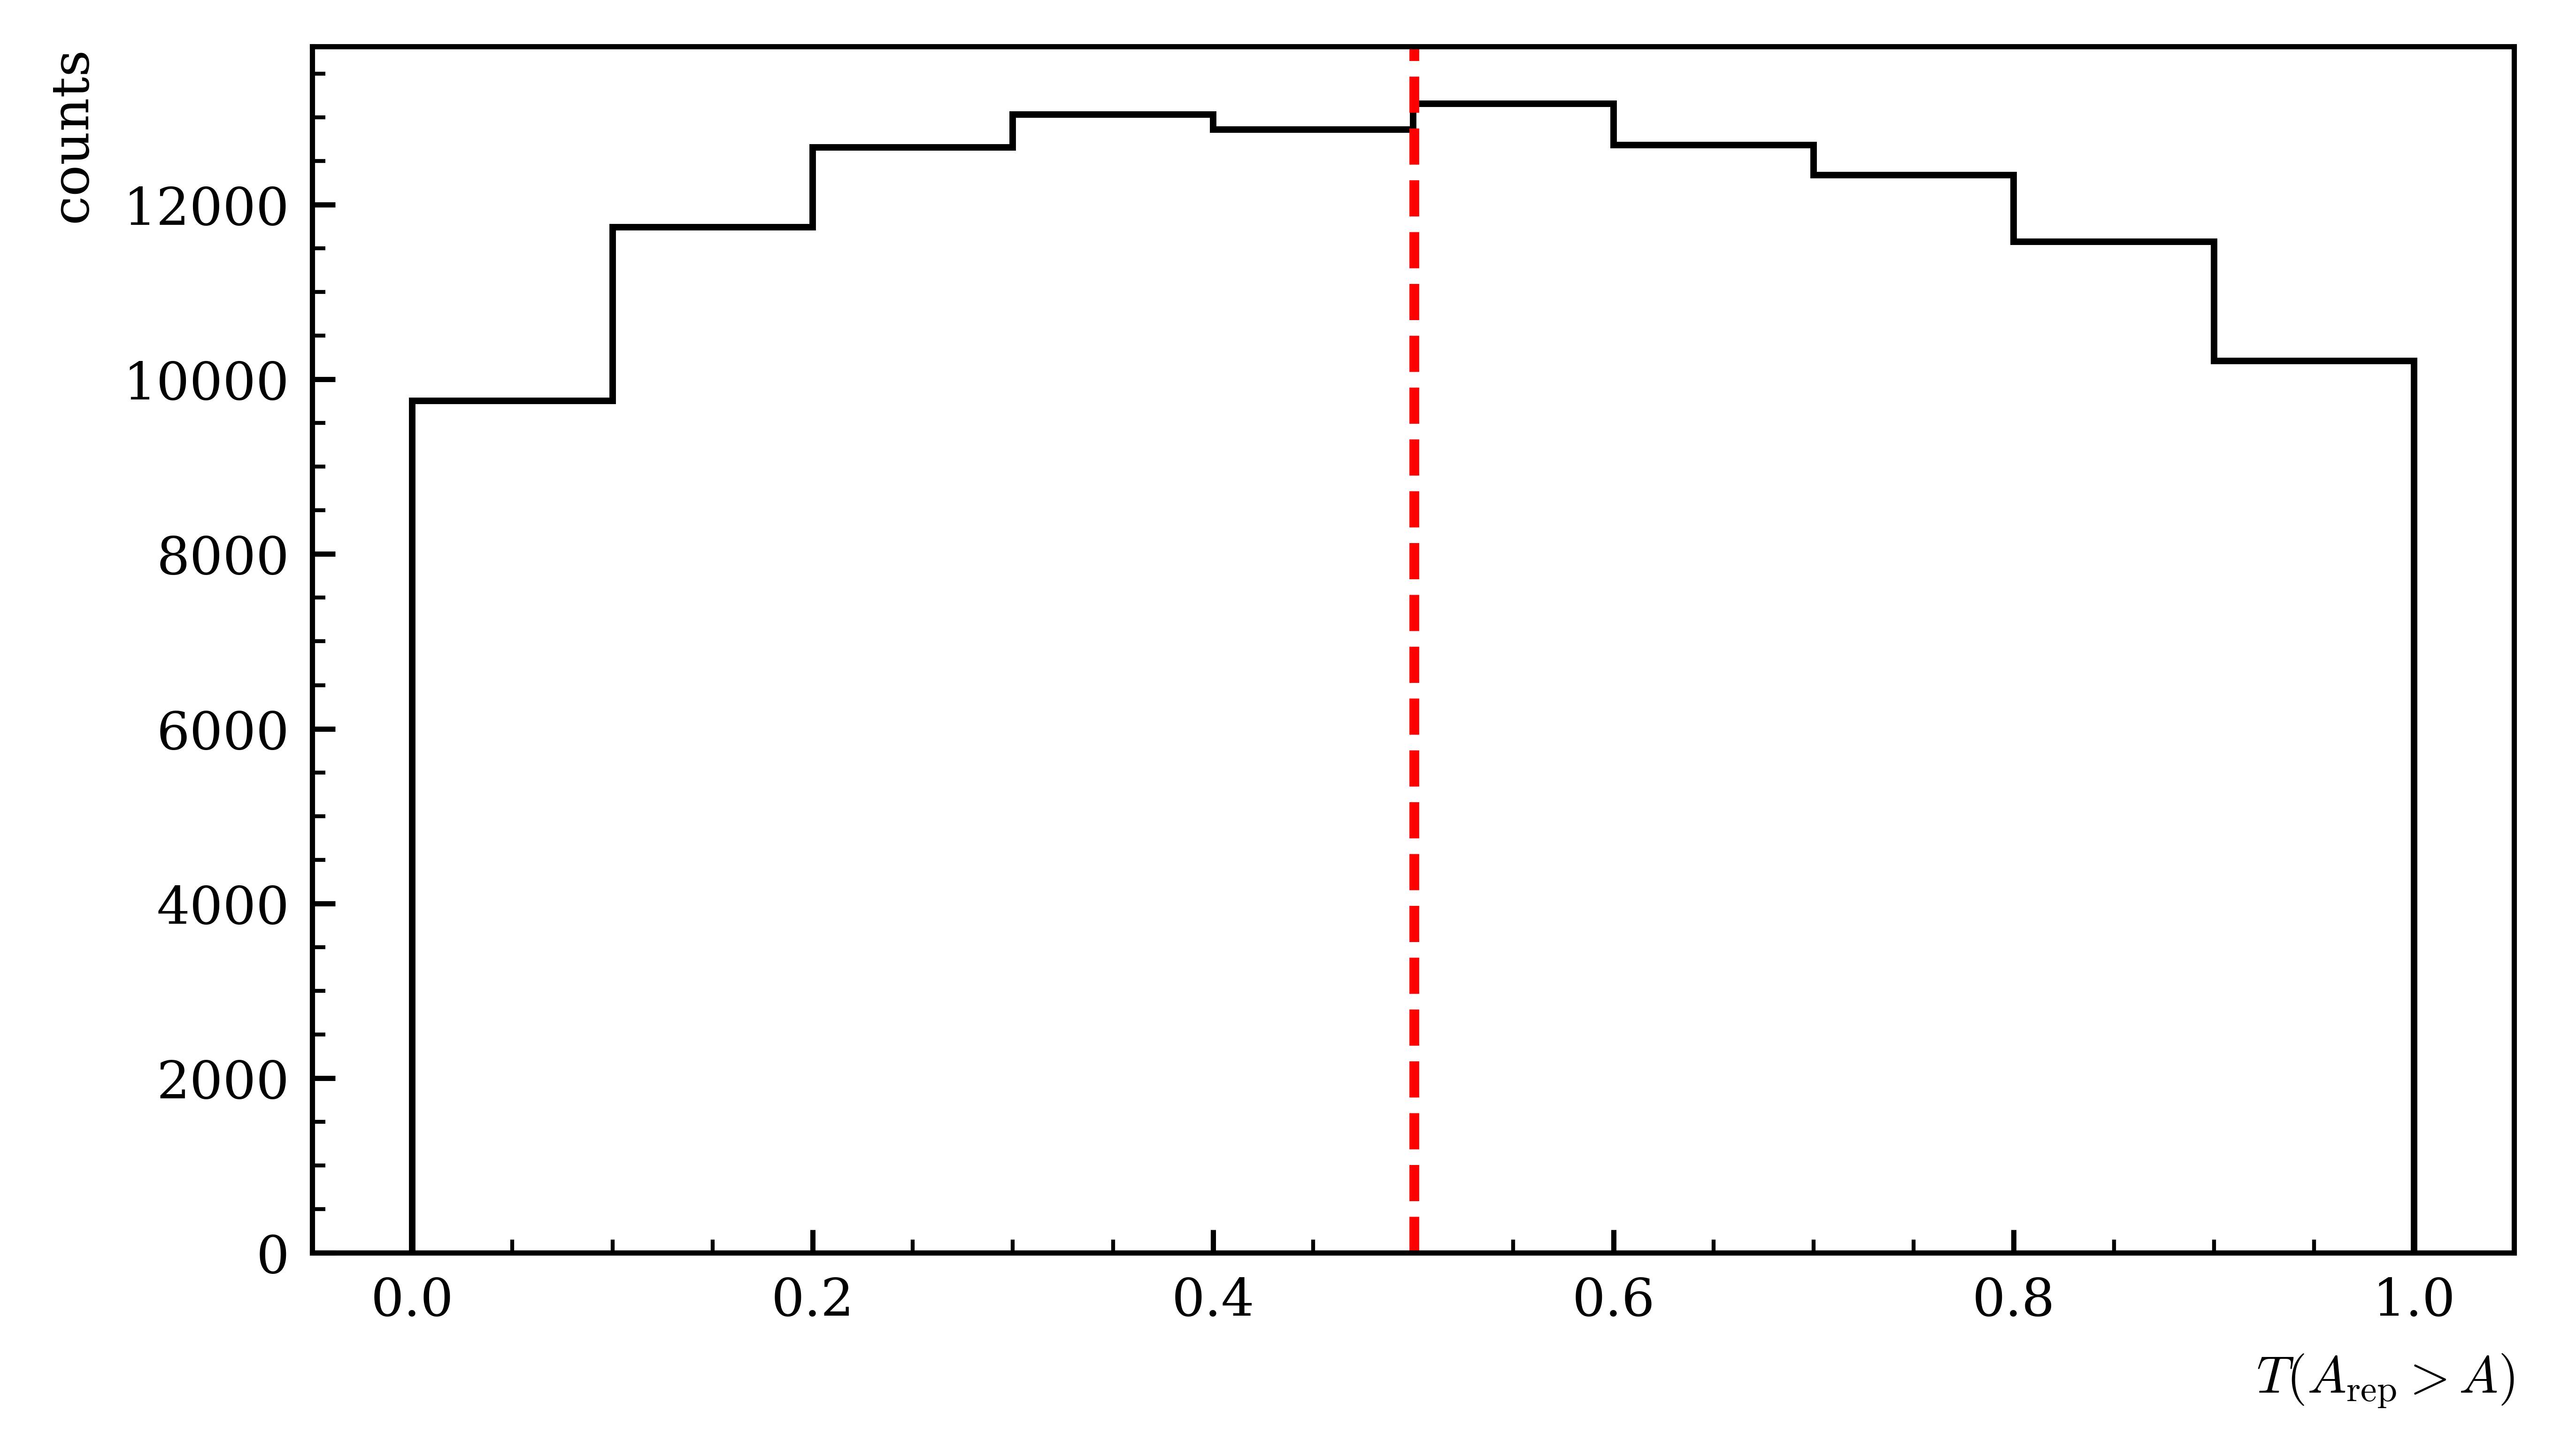

In [33]:
plt.rcParams['font.size']=8
binlist=[f"toybin{i:04d}" for i in range(10000)]
pvals=diagnostics_df.loc[[f'pval{i:02d}' for i in range(12)]][binlist]
fig, ax = plt.subplots(dpi=1000,figsize=[15.3728/2.54,8.6472/2.54])
ax.hist(pvals.values.ravel(),histtype='step')
ax.set_xlabel('$T(A_\mathrm{rep}>A)$',horizontalalignment='right',x=1.0)
ax.set_ylabel('counts',horizontalalignment='right',y=1.0)
#ax.axvline(x=0.5,color='red')
ax.axvline(x=np.mean(pvals.values.ravel()),color='red',ls='--')
ax.tick_params(axis='both',which='both',direction='in')
plt.show()
fig.savefig('./plots/toyMC_pval_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')

#len(pvals.values.ravel())

# Combined posterior distributions of all fits

In [38]:
all_sigmas=[]
for i in range(10000):
    all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)-0.3))


In [63]:
h=r.TH1D("h","h",100,-1,1)
for i in range(len(all_sigmas)):
    h.Fill(all_sigmas[i])


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [64]:
c=r.TCanvas("c","c")
c.Draw("")
c.SetBottomMargin(0.15)
h.Draw("")
h.GetXaxis().SetLabelFont(133)
h.GetYaxis().SetLabelFont(133)
h.GetXaxis().SetTitleFont(133)
h.GetYaxis().SetTitleFont(133)
h.GetYaxis().SetTitle("counts")
h.GetXaxis().SetTitle("#Xi")
#h.GetXaxis().SetTitle("#font[132]{p(#Sigma|D_{#it{i}})}")
h.SetTitle("")
h.GetYaxis().SetNdivisions(1)
h.GetYaxis().SetLabelSize(50)
h.GetYaxis().SetTitleSize(50)
h.GetXaxis().SetTitleSize(50)
h.GetXaxis().SetLabelSize(50)
c.SetLeftMargin(0.15)
r.gStyle.SetOptStat(0)
h.GetXaxis().SetTitleOffset(1.5)
f=r.TF1("f","gaus",-5,5)
h.Fit(f,"S")
h.GetXaxis().SetRangeUser(-1,1)
t=r.TLatex()
t.SetTextAlign(22)
t.SetTextFont(133)
t.SetTextSize(50)
mu = f.GetParameter(1)
mu_err = f.GetParError(1)
sigma=f.GetParameter(2)
sigma_err=f.GetParError(2)
t.DrawLatex(0,5e3,f"#color[2]{{#mu={mu:.4f}#pm{mu_err:.4f}, #sigma={sigma:.4f}#pm{sigma_err:.4f}}}")

 FCN=1343.5 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=5.54438e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.90407e+06   3.69078e+02   5.38304e+00  -3.04263e-07
   2  Mean        -1.35597e-02   2.65084e-05   4.74546e-07  -3.15358e-02
   3  Sigma        1.67613e-01   1.87970e-05   5.45889e-07  -3.12741e+00


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [18]:
sigma_chi2_df=pd.read_csv('./sigma_chi2.csv',index_col=0)


In [19]:
h1=r.TH1D("h1","h1",25,-5,5)
for i in range(len(sigma_chi2_df.columns)):
    h1.Fill((sigma_chi2_df[f'toybin{i:04d}']['sigma']-0.3)/sigma_chi2_df[f'toybin{i:04d}']['error'])

In [20]:
c1=r.TCanvas("c1","c")
c1.Draw("")
c1.SetBottomMargin(0.15)
h1.Draw("")
h1.Fit("gaus","S")



 FCN=87.3146 FROM MIGRAD    STATUS=CONVERGED      62 CALLS          63 TOTAL
                     EDM=1.81935e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.38101e+03   1.81374e+01   6.36775e-02  -2.81536e-06
   2  Mean        -8.45858e-02   1.15012e-02   5.27744e-05  -3.31883e-03
   3  Sigma        1.14440e+00   9.67896e-03   9.73968e-06  -2.73654e-03


In [65]:
#c.SaveAs("./plots/combined_post_add.pdf")
#c.SaveAs("./plots/combined_post_add.root")
#c.SaveAs("./plots/combined_post_add_raw.pdf")
c.SaveAs("./plots/combined_post_add_raw.root")

Info in <TCanvas::SaveAs>: ROOT file ./plots/combined_post_add_raw.root has been created


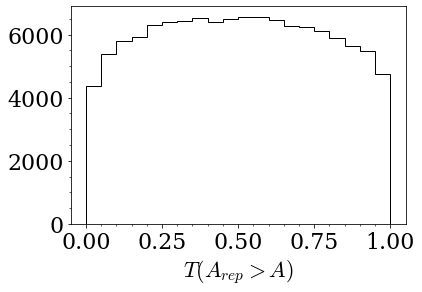

In [25]:
plt.hist(diagnostics_df.loc[[f'pval{i:02d}' for i in range(12)]].values.ravel(),histtype='step',bins=20)
plt.xlabel(r'$T(A_{rep}>A)$')
plt.grid(False)
plt.savefig('./plots/toyMC_pval_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

In [ ]:
h1.GetEntries()

In [ ]:
h.GetEntries()

In [11]:
x=np.linspace(-180,180,360)

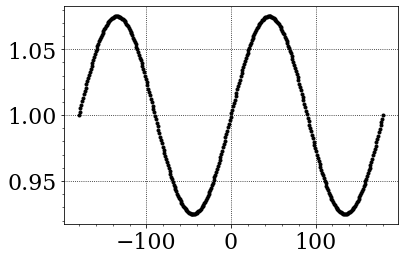

In [12]:
plt.plot(x,1-0.3*0.25*np.cos(2*(-45-x)*np.pi/180.),'.')
plt.show()

In [15]:
import random

In [16]:
x=np.linspace(-180,180,10000)
fx=1-0.5*0.25*np.cos(2*(-45-x)*np.pi/180.)

In [17]:
hx=random.choices(x,fx,k=10000)

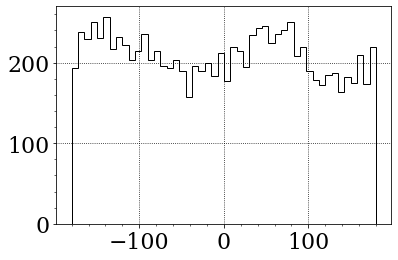

In [18]:
plt.hist(hx,histtype='step',bins=48)
plt.show()

In [26]:
h=r.TH1F("h",";#phi;",48,-180,180)
f=r.TF1("f","[0]*(1-0.25*[1]*cos(2*(-45-x)*TMath::Pi()/180.))")

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [27]:
for i in range(4000):
    h.Fill(hx[i])

In [28]:
c=r.TCanvas()
c.Draw()
h.Draw("ep")
h.Fit(f,"S")

 FCN=54.6112 FROM MIGRAD    STATUS=CONVERGED      91 CALLS          92 TOTAL
                     EDM=3.50039e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.21753e+01   1.30842e+00   4.76431e-03   6.14765e-04
   2  p1           4.33303e-01   8.92470e-02   3.24894e-04  -2.58056e-03
